## Data loading

In [ ]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
ascad_path = "/content/drive/MyDrive/ASCAD_databases/ASCAD.h5"

with h5py.File(ascad_path, "r") as f:
  X_profiling = np.array(f['Profiling_traces/traces'], dtype=np.float32)
  Y_profiling = np.array(f['Profiling_traces/labels'], dtype=np.int64)

In [ ]:
TEST_SIZE=0.1
RANDOM_STATE=42

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_profiling, Y_profiling, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [ ]:
# recover metadata idxs
all_idxs = np.arange(len(X_profiling))
tr_idx, val_idx = train_test_split(all_idxs, test_size=0.1, random_state=42)

In [ ]:
with h5py.File(ascad_path, "r") as f:
  metadata = np.array(f['Profiling_traces/metadata'])

In [ ]:
metadata[val_idx].shape

(5000,)

In [ ]:
print("Training set:", X_train.shape, Y_train.shape)
print("Validation set:", X_val.shape, Y_val.shape)

Training set: (45000, 700) (45000,)
Validation set: (5000, 700) (5000,)


In [ ]:
print(X_profiling.min())
print(X_profiling.max())
print(X_profiling.dtype)

-66.0
47.0
float32


In [ ]:
X_train = X_train[..., np.newaxis]  # (45000, 700, 1)
X_val   = X_val[..., np.newaxis] # (5000, 700, 1)

In [ ]:
print(X_train.shape)
print(X_val.shape)

(45000, 700, 1)
(5000, 700, 1)


## GaussiP

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class GaussianAttention(tf.keras.layers.Layer):
    def __init__(self, seq_len, n_heads, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.n_heads = n_heads

    def build(self, input_shape):
        # Learnable Gaussian parameters
        self.mu = self.add_weight(
            shape=(self.n_heads,), initializer="uniform", trainable=True, name="mu"
        )
        self.sigma = self.add_weight(
            shape=(self.n_heads,), initializer="ones", trainable=True, name="sigma"
        )

        # Define projection layer once
        self.proj = tf.keras.layers.Dense(self.n_heads)

    def call(self, inputs):
        B = tf.shape(inputs)[0]
        T = self.seq_len
        C = tf.shape(inputs)[2]

        # Time indices
        time = tf.range(0, T, dtype=tf.float32)
        time = tf.reshape(time, (1, T, 1))  # (1, T, 1)

        mu = tf.reshape(self.mu, (1, 1, self.n_heads))
        sigma = tf.reshape(self.sigma, (1, 1, self.n_heads))

        weights = tf.exp(-0.5 * ((time - mu) / (sigma + 1e-6))**2)
        weights /= tf.reduce_sum(weights, axis=1, keepdims=True)

        # Project input to H heads
        proj = self.proj(inputs)  # (B, T, H)

        # Attention-weighted sum
        attended = tf.reduce_sum(proj * weights, axis=1)  # (B, H)
        return attended


In [ ]:
gaussiP = GaussianAttention(seq_len=700, n_heads=8)

In [ ]:
B, T, C = 4, 700, 32
x_dummy = tf.random.normal((B, T, C))

gaussiP(x_dummy)

<tf.Tensor: shape=(4, 8), dtype=float32, numpy=
array([[-0.6636417 , -0.9346667 ,  0.02314144, -0.51486015,  0.36456698,
         0.04866207, -0.47266394,  1.6978714 ],
       [ 0.83375746,  0.2719422 , -0.07218313, -0.00567518, -0.41662747,
         0.9309354 , -0.6217215 ,  0.09150785],
       [-1.4113367 , -0.17865631,  1.5975788 , -0.87570345, -1.9237615 ,
        -1.0847723 ,  2.3716407 ,  0.9732932 ],
       [-0.58643985,  0.34906602, -0.997382  ,  0.6554553 , -1.2339805 ,
        -0.5940348 ,  1.4446781 , -0.6868641 ]], dtype=float32)>

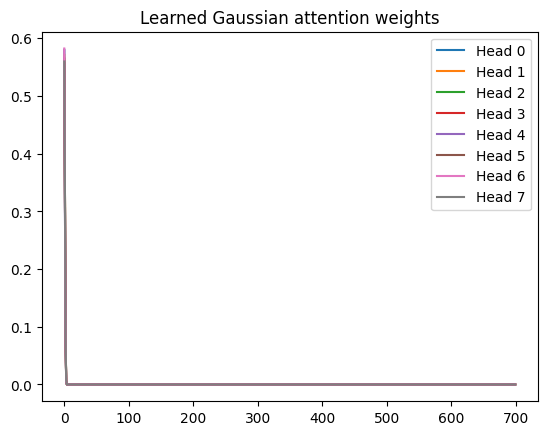

In [ ]:
time = tf.range(0, 700, dtype=tf.float32)
mu = gaussiP.mu.numpy()
sigma = gaussiP.sigma.numpy()

import matplotlib.pyplot as plt

for i in range(8):
    w = tf.exp(-0.5 * ((time - mu[i]) / (sigma[i] + 1e-6))**2)
    w /= tf.reduce_sum(w)
    plt.plot(w, label=f'Head {i}')
plt.title("Learned Gaussian attention weights")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, ReLU, Dense
from tensorflow.keras.models import Model

def build_estranet(seq_len=700, num_classes=256, n_heads=8, conv_filters=32):
    inputs = Input(shape=(seq_len, 1))

    # 1. Convolutional feature extractor
    x = Conv1D(conv_filters, kernel_size=5, padding='same')(inputs)
    x = ReLU()(x)

    # 2. Gaussian attention block
    attn = GaussianAttention(seq_len=seq_len, n_heads=n_heads)(x)

    # 3. Classification head
    outputs = Dense(num_classes)(attn)  # logits

    model = Model(inputs, outputs, name="EstraNet")
    return model


In [ ]:
model = build_estranet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
hist = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=128,
    epochs=100
)

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.0034 - loss: 5.5931 - val_accuracy: 0.0064 - val_loss: 5.5451
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0051 - loss: 5.5455 - val_accuracy: 0.0058 - val_loss: 5.5454
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0046 - loss: 5.5440 - val_accuracy: 0.0058 - val_loss: 5.5454
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0042 - loss: 5.5436 - val_accuracy: 0.0062 - val_loss: 5.5461
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0053 - loss: 5.5433 - val_accuracy: 0.0040 - val_loss: 5.5485
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0043 - loss: 5.5426 - val_accuracy: 0.0044 - val_loss: 5.5497
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0055 - loss: 5.5417 - val_accuracy: 0.0056 - val_loss: 5.5488
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0048 - loss: 5.5416 - val_ac

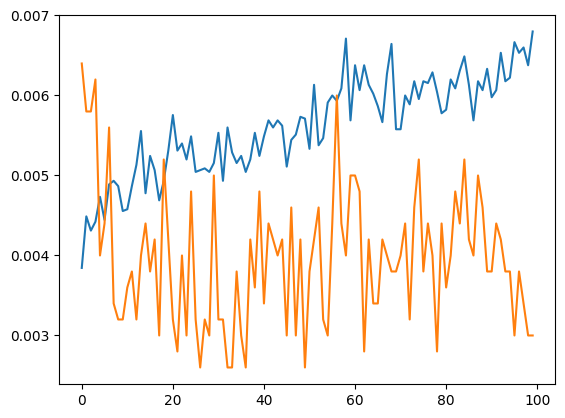

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

In [ ]:
## Bump CNN encoder

from tensorflow.keras.layers import Input, Conv1D, ReLU, Dense
from tensorflow.keras.models import Model

def build_estranet_2(seq_len=700, num_classes=256, n_heads=8, conv_filters=32):
    inputs = Input(shape=(seq_len, 1))

    # 1st Conv layer
    x = Conv1D(32, kernel_size=11, padding='same')(inputs)
    x = ReLU()(x)

    # 2nd Conv layer
    x = Conv1D(64, kernel_size=5, padding='same')(x)
    x = ReLU()(x)

    # 3rd Conv layer
    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = ReLU()(x)

    # 2. Gaussian attention block
    attn = GaussianAttention(seq_len=seq_len, n_heads=n_heads)(x)

    # 3. Classification head
    outputs = Dense(num_classes)(attn)  # logits

    model = Model(inputs, outputs, name="EstraNet")
    return model


In [ ]:
estra_2 = build_estranet_2()
estra_2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
hist_2 = estra_2.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=128,
    epochs=100
)

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.0040 - loss: 5.5489 - val_accuracy: 0.0044 - val_loss: 5.5449
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0040 - loss: 5.5443 - val_accuracy: 0.0044 - val_loss: 5.5446
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0047 - loss: 5.5438 - val_accuracy: 0.0044 - val_loss: 5.5448
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0049 - loss: 5.5429 - val_accuracy: 0.0044 - val_loss: 5.5448
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0053 - loss: 5.5426 - val_accuracy: 0.0044 - val_loss: 5.5449
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0048 - loss: 5.5427 - val_accuracy: 0.0044 - val_loss: 5.5452
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0052 - loss: 5.5427 - val_accuracy: 0.0044 - val_loss: 5.5452
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0050 - loss: 5.5426 - val_ac

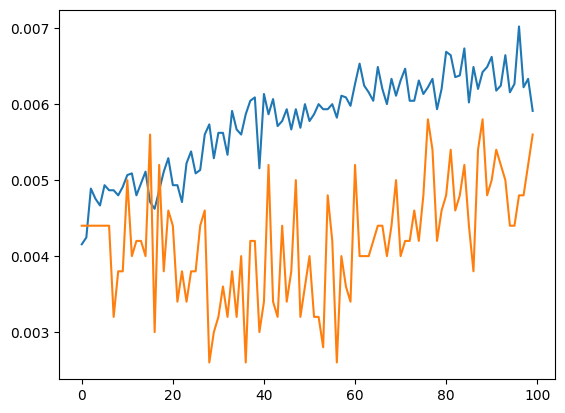

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])

### Plot the attention heads

In [ ]:
import matplotlib.pyplot as plt

def plot_attention_heads(attention_layer, snr=None):
    mu_vals = attention_layer.mu.numpy()
    sigma_vals = attention_layer.sigma.numpy()
    time = np.arange(attention_layer.seq_len)

    plt.figure(figsize=(10, 4))
    for i in range(len(mu_vals)):
        gauss = np.exp(-0.5 * ((time - mu_vals[i]) / (sigma_vals[i] + 1e-6)) ** 2)
        gauss /= gauss.sum()
        plt.plot(time, gauss, label=f"Head {i}")

    if snr is not None:
      plt.plot(snr, label="SNR")

    plt.title("Gaussian Attention Weights (Learned)")
    plt.xlabel("Time index")
    plt.ylabel("Weight")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Call it on the actual layer instance
plot_attention_heads(estra_2.get_layer('gaussian_attention_4'))

### GaussiP latest

In [ ]:
# Use this attention - μ & σ initialized properly

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class GaussianAttention(tf.keras.layers.Layer):
    def __init__(self, seq_len, n_heads, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.n_heads = n_heads

    def build(self, input_shape):
      # μ initialization
      init_mu = tf.keras.initializers.RandomUniform(minval=100.0, maxval=self.seq_len)
      self.mu = self.add_weight(
          shape=(self.n_heads,),
          initializer=init_mu,
          trainable=True,
          name="mu"
      )

      # σ initialization (wider spread)
      init_sigma = tf.keras.initializers.Constant(value=30.0)
      self.sigma = self.add_weight(
          shape=(self.n_heads,),
          initializer=init_sigma,
          trainable=True,
          name="sigma"
      )

      # Static projection to attention heads
      self.proj = tf.keras.layers.Dense(self.n_heads)

    def call(self, inputs):
        B = tf.shape(inputs)[0]
        T = self.seq_len
        C = tf.shape(inputs)[2]

        # Time indices
        time = tf.range(0, T, dtype=tf.float32)
        time = tf.reshape(time, (1, T, 1))  # (1, T, 1)

        mu = tf.reshape(self.mu, (1, 1, self.n_heads))
        sigma = tf.reshape(self.sigma, (1, 1, self.n_heads))

        weights = tf.exp(-0.5 * ((time - mu) / (sigma + 1e-6))**2)
        weights /= tf.reduce_sum(weights, axis=1, keepdims=True)

        # Project input to H heads
        proj = self.proj(inputs)  # (B, T, H)

        # Attention-weighted sum
        attended = tf.reduce_sum(proj * weights, axis=1)  # (B, H)
        return attended


In [ ]:
estra_3 = build_estranet_2()
estra_3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
hist_3 = estra_3.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=128,
    epochs=100
)

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.0037 - loss: 5.5538 - val_accuracy: 0.0036 - val_loss: 5.5451
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0046 - loss: 5.5442 - val_accuracy: 0.0044 - val_loss: 5.5448
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0047 - loss: 5.5436 - val_accuracy: 0.0044 - val_loss: 5.5446
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0049 - loss: 5.5433 - val_accuracy: 0.0044 - val_loss: 5.5448
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0047 - loss: 5.5435 - val_accuracy: 0.0044 - val_loss: 5.5449
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0046 - loss: 5.5430 - val_accuracy: 0.0044 - val_loss: 5.5449
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0046 - loss: 5.5427 - val_accuracy: 0.0044 - val_loss: 5.5451
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0046 - loss: 5.5432 - val_acc

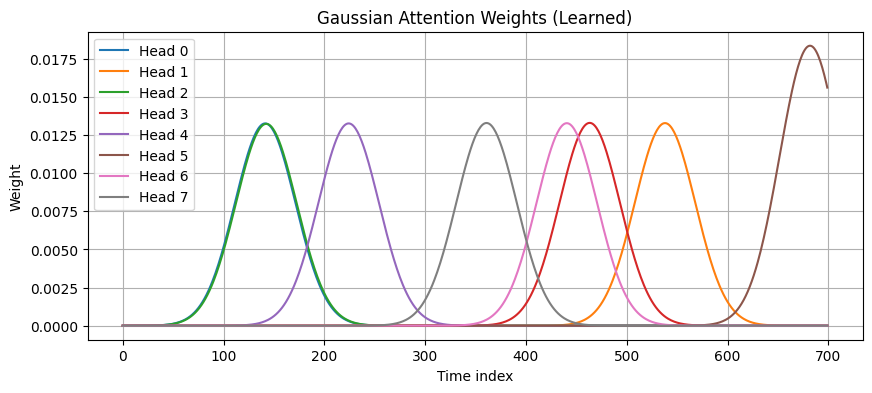

In [ ]:
plot_attention_heads(estra_3.get_layer('gaussian_attention_5'))

## Estra 3 - grow the dense layers

In [ ]:
## Bump CNN encoder

from tensorflow.keras.layers import Input, Conv1D, ReLU, Dense, Dropout
from tensorflow.keras.models import Model

def build_estranet_3(seq_len=700, num_classes=256, n_heads=8, conv_filters=32):
    inputs = Input(shape=(seq_len, 1))

    # 1st Conv layer
    x = Conv1D(32, kernel_size=11, padding='same')(inputs)
    x = ReLU()(x)

    # 2nd Conv layer
    x = Conv1D(64, kernel_size=5, padding='same')(x)
    x = ReLU()(x)

    # 3rd Conv layer
    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = ReLU()(x)

    # 2. Gaussian attention block
    attn = GaussianAttention(seq_len=seq_len, n_heads=n_heads)(x)

    x = attn  # output from GaussianAttention

    # 1. Dense block
    x = Dense(64)(x)
    x = ReLU()(x)
    x = Dropout(0.2)(x)

    # 2. Dense block 2
    x = Dense(64)(x)
    x = ReLU()(x)
    x = Dropout(0.2)(x)

    outputs = Dense(256)(x)

    model = Model(inputs, outputs, name="EstraNet")
    return model


In [ ]:
estra_4 = build_estranet_3()
estra_4.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
hist_4 = estra_4.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=128,
    epochs=100
)

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.0032 - loss: 5.5476 - val_accuracy: 0.0044 - val_loss: 5.5447
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0047 - loss: 5.5441 - val_accuracy: 0.0044 - val_loss: 5.5446
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0054 - loss: 5.5430 - val_accuracy: 0.0044 - val_loss: 5.5447
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0051 - loss: 5.5426 - val_accuracy: 0.0044 - val_loss: 5.5447
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0049 - loss: 5.5427 - val_accuracy: 0.0044 - val_loss: 5.5450
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0044 - loss: 5.5425 - val_accuracy: 0.0044 - val_loss: 5.5451
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0047 - loss: 5.5427 - val_accuracy: 0.0044 - val_loss: 5.5452
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0045 - loss: 5.5428 - val_ac

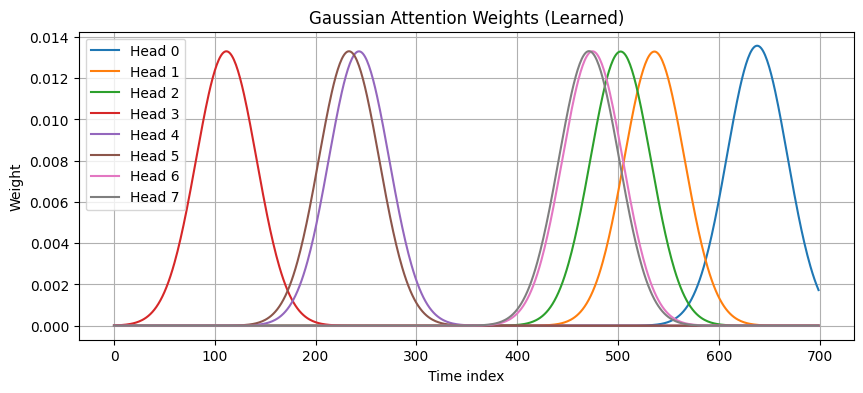

In [ ]:
plot_attention_heads(estra_4.get_layer('gaussian_attention_8'))

## Estra 4 - more expressiveness

In [ ]:
## Bump CNN encoder

from tensorflow.keras.layers import Input, Conv1D, ReLU, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

def build_estranet_4(seq_len=700, num_classes=256, n_heads=8, conv_filters=32):
    inputs = Input(shape=(seq_len, 1))

    # 1st Conv layer
    x = Conv1D(32, kernel_size=11, padding='same')(inputs)
    x = ReLU()(x)

    # 2nd Conv layer
    x = Conv1D(64, kernel_size=5, padding='same')(x)
    x = ReLU()(x)

    # 3rd Conv layer
    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = ReLU()(x)

    # 2. Gaussian attention block
    attn = GaussianAttention(seq_len=seq_len, n_heads=n_heads)(x)

    x = attn  # output from GaussianAttention

    x = Dense(128)(attn)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(128)(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(256)(x)

    model = Model(inputs, outputs, name="EstraNet")
    return model


In [ ]:
estra_5 = build_estranet_4()
estra_5.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
hist_5 = estra_5.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=128,
    epochs=100
)

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.0032 - loss: 5.8303 - val_accuracy: 0.0028 - val_loss: 5.5996
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0038 - loss: 5.6570 - val_accuracy: 0.0052 - val_loss: 5.6741
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0040 - loss: 5.6226 - val_accuracy: 0.0042 - val_loss: 5.6660
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0036 - loss: 5.6008 - val_accuracy: 0.0050 - val_loss: 5.9442
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0049 - loss: 5.5824 - val_accuracy: 0.0036 - val_loss: 6.0396
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0043 - loss: 5.5703 - val_accuracy: 0.0034 - val_loss: 5.7160
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0056 - loss: 5.5554 - val_accuracy: 0.0036 - val_loss: 8.9445
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0051 - loss: 5.5492 - val_ac

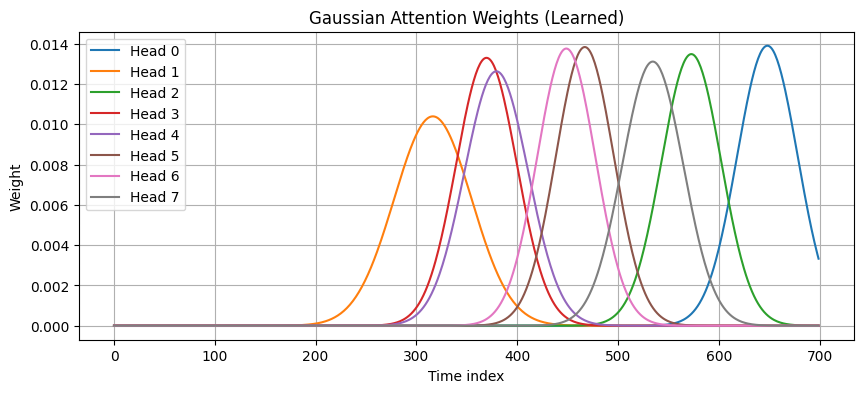

In [ ]:
plot_attention_heads(estra_5.get_layer('gaussian_attention'))

In [ ]:
from tqdm import tqdm

def rank(predictions, metadata, real_key, traces_idxs, last_key_bytes_proba, target_byte, simulated_key):
	# Compute the rank
	if len(last_key_bytes_proba) == 0:
		# If this is the first rank we compute, initialize all the estimates to zero
		key_bytes_proba = np.zeros(256)
	else:
		# This is not the first rank we compute: we optimize things by using the
		# previous computations to save time!
		key_bytes_proba = last_key_bytes_proba

	for t_idx in traces_idxs:
		# Go back from the class to the key byte. '2' is the index of the byte (third byte) of interest.
		plaintext = metadata[t_idx]['plaintext'][target_byte]
		key = metadata[t_idx]['key'][target_byte]
		for key_guess in range(0, 256):
			# Our candidate key byte probability is the sum of the predictions logs
			if (simulated_key!=1):
				proba = predictions[t_idx][SBOX[plaintext ^ key_guess]]
			else:
				proba = predictions[t_idx][SBOX[plaintext ^ key ^ key_guess]]
			if proba != 0:
				key_bytes_proba[key_guess] += np.log(proba)
			else:
				# We do not want an -inf here, put a very small epsilon
				# that correspondis to a power of our min non zero proba
				min_proba_predictions = predictions[t_idx][np.array(predictions[t_idx]) != 0]
				if len(min_proba_predictions) == 0:
					print("Error: got a prediction with only zeroes ... this should not happen!")
					sys.exit(-1)
				min_proba = min(min_proba_predictions)
				key_bytes_proba[key_guess] += np.log(min_proba**2)
	# Now we find where our real key candidate lies in the estimation.
	# We do this by sorting our estimates and find the rank in the sorted array.
	sorted_proba = np.array(list(map(lambda a : key_bytes_proba[a], key_bytes_proba.argsort()[::-1])))
	real_key_rank = np.where(sorted_proba == key_bytes_proba[real_key])[0][0]
	return (real_key_rank, key_bytes_proba)

def run_rank_trials(predictions, metadata, n_traces_per_trial=1000, n_trials=10, rank_step=10, target_byte=2, simulated_key=0):
    real_key = metadata[0]['key'][target_byte] if not simulated_key else 0

    max_trace_idx = predictions.shape[0]
    steps = list(range(rank_step, n_traces_per_trial + 1, rank_step))

    all_ranks = []

    for trial in tqdm(range(n_trials), desc="Trials"):
        trace_indices = np.random.choice(np.arange(max_trace_idx), size=n_traces_per_trial, replace=False)
        trial_ranks = []
        key_bytes_proba = []

        for i in tqdm(steps, leave=False, desc=f"Rank steps (Trial {trial+1})"):
            selected = trace_indices[:i]
            rank_val, key_bytes_proba = rank(predictions, metadata, real_key, selected, key_bytes_proba, target_byte, simulated_key)
            trial_ranks.append(rank_val)

        all_ranks.append(trial_ranks)

    return steps, np.array(all_ranks)

def plot_mean_rank(steps, ranks_matrix):
    import matplotlib.pyplot as plt
    mean_ranks = np.mean(ranks_matrix, axis=0)
    std_ranks = np.std(ranks_matrix, axis=0)

    plt.plot(steps, mean_ranks, label='Mean Rank')
    plt.fill_between(steps, mean_ranks - std_ranks, mean_ranks + std_ranks, alpha=0.3, label='±1 std dev')
    plt.xlabel("Number of traces")
    plt.ylabel("Rank of correct key")
    plt.title("Mean key rank across trials")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
SBOX =  np.array(
        [0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67,
        0x2b, 0xfe, 0xd7, 0xab, 0x76, 0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59,
        0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0, 0xb7,
        0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1,
        0x71, 0xd8, 0x31, 0x15, 0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05,
        0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75, 0x09, 0x83,
        0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29,
        0xe3, 0x2f, 0x84, 0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
        0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf, 0xd0, 0xef, 0xaa,
        0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c,
        0x9f, 0xa8, 0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc,
        0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2, 0xcd, 0x0c, 0x13, 0xec,
        0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19,
        0x73, 0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee,
        0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb, 0xe0, 0x32, 0x3a, 0x0a, 0x49,
        0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
        0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4,
        0xea, 0x65, 0x7a, 0xae, 0x08, 0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6,
        0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a, 0x70,
        0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9,
        0x86, 0xc1, 0x1d, 0x9e, 0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e,
        0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf, 0x8c, 0xa1,
        0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0,
        0x54, 0xbb, 0x16])

### Evaluate on validation set

Run a quick check on validation set - not leaking the test set (attack data).

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Trials: 100%|██████████| 10/10 [04:21<00:00, 26.18s/it]


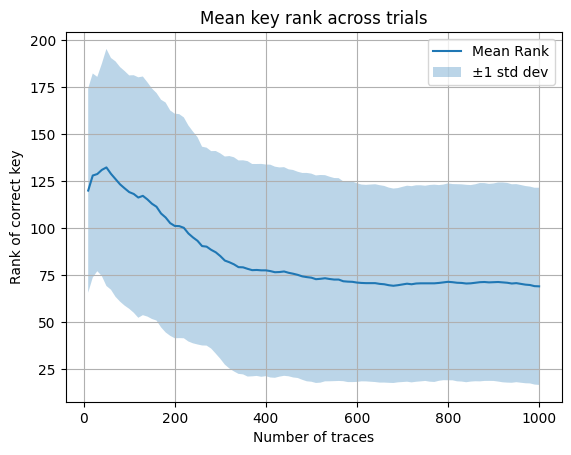

In [ ]:
predictions = estra_5.predict(X_val)
probas = tf.nn.softmax(predictions, axis=1).numpy()
steps, ranks = run_rank_trials(probas, metadata[val_idx], n_traces_per_trial=1000, n_trials=10)
plot_mean_rank(steps, ranks)

(256,)

### Estra - Stackable attention heads

In [ ]:
from tensorflow.keras.layers import Dense, ReLU, BatchNormalization, Dropout, Add

def GaussianTransformerBlock(x_in, seq_len, n_heads, ffn_dim=128, dropout_rate=0.3, name_prefix="gblock"):
    attn_out = GaussianAttention(seq_len=seq_len, n_heads=n_heads, name=f"{name_prefix}_attn")(x_in)

    if x_in.shape[-1] != attn_out.shape[-1]:
        x_proj = Dense(attn_out.shape[-1])(x_in)
    else:
        x_proj = x_in

    x = Add()([x_proj, attn_out])
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    ffn = Dense(ffn_dim)(x)
    ffn = ReLU()(ffn)
    ffn = Dense(attn_out.shape[-1])(ffn)

    x = Add()([x, ffn])
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    return x

In [ ]:
## Stack Gaussi attentions

from tensorflow.keras.layers import Input, Conv1D, ReLU, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model

def build_estranet_stackable(seq_len=700, num_classes=256, n_heads=8, conv_filters=32, gaussip_attn_layers=1):
    inputs = Input(shape=(seq_len, 1))

    # 1st Conv layer
    x = Conv1D(32, kernel_size=11, padding='same')(inputs)
    x = ReLU()(x)

    # 2nd Conv layer
    x = Conv1D(64, kernel_size=5, padding='same')(x)
    x = ReLU()(x)

    # 3rd Conv layer
    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = ReLU()(x)

    # 2. Gaussian attention block
    for i in range(gaussip_attn_layers):
      x = GaussianTransformerBlock(x, seq_len=seq_len, n_heads=n_heads, ffn_dim=128, name_prefix=f"GaussiTrfmrBlock{i}")

    x = GlobalAveragePooling1D()(x)

    # x = Dense(128)(attn)
    # x = ReLU()(x)
    # x = BatchNormalization()(x)
    # x = Dropout(0.3)(x)

    x = Dense(128)(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(256)(x)

    model = Model(inputs, outputs, name="EstraNet")
    return model


In [ ]:
 estra_stackable_1 = build_estranet_stackable(gaussip_attn_layers=3)

In [ ]:
estra_stackable_1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
estra_stackable_1.summary()

Model: "EstraNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 700, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 700, 32)   │        384 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 700, 32)   │          0 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 700, 64)   │     10,304 │ re_lu_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 700, 64)   │          0 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 700, 128)  │     24,704 │ re_lu_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 700, 128)  │          0 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 700, 8)    │      1,032 │ re_lu_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GaussiTrfmrBlock[0… │ (None, 8)         │      1,048 │ re_lu_11[0][0]    │
│ (GaussianAttention) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 700, 8)    │          0 │ dense_12[0][0],   │
│                     │                   │            │ GaussiTrfmrBlock… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 700, 8)    │         32 │ add_6[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 700, 8)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 700, 128)  │      1,152 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 700, 128)  │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 700, 8)    │      1,032 │ re_lu_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 700, 8)    │          0 │ dropout_6[0][0],  │
│                     │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 700, 8)    │         32 │ add_7[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 700, 8)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GaussiTrfmrBlock[1… │ (None, 8)         │         88 │ dropout_7[0][0]   │
│ (GaussianAttention) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 700, 8)    │          0 │ dropout_7[0][0],  │
│                     │                   │            │ GaussiTrfmrBlock… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 700, 8)    │         32 │ add_8[0][0]     

 Total params: 46,696 (182.41 KB)

 Trainable params: 46,600 (182.03 KB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
hist_stackable_1 = estra_stackable_1.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=128,
    epochs=100
)

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 50s 75ms/step - accuracy: 0.0035 - loss: 5.5455 - val_accuracy: 0.0048 - val_loss: 5.5468
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.0044 - loss: 5.5442 - val_accuracy: 0.0044 - val_loss: 5.5455
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.0049 - loss: 5.5437 - val_accuracy: 0.0044 - val_loss: 5.5451
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.0047 - loss: 5.5434 - val_accuracy: 0.0044 - val_loss: 5.5498
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.0044 - loss: 5.5427 - val_accuracy: 0.0044 - val_loss: 5.5479
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.0045 - loss: 5.5424 - val_accuracy: 0.0050 - val_loss: 5.5480
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.0046 - loss: 5.5427 - val_accuracy: 0.0050 - val_loss: 5.5620
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.0055 - loss: 5.5402 -

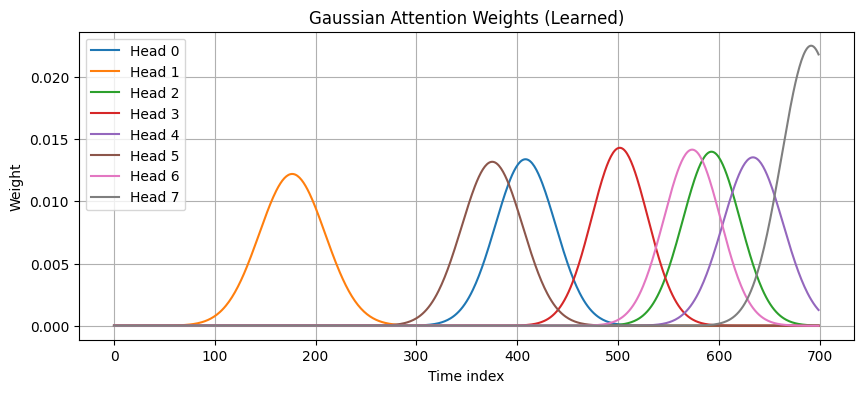

In [ ]:
plot_attention_heads(estra_stackable_1.get_layer('GaussiTrfmrBlock0_attn'))

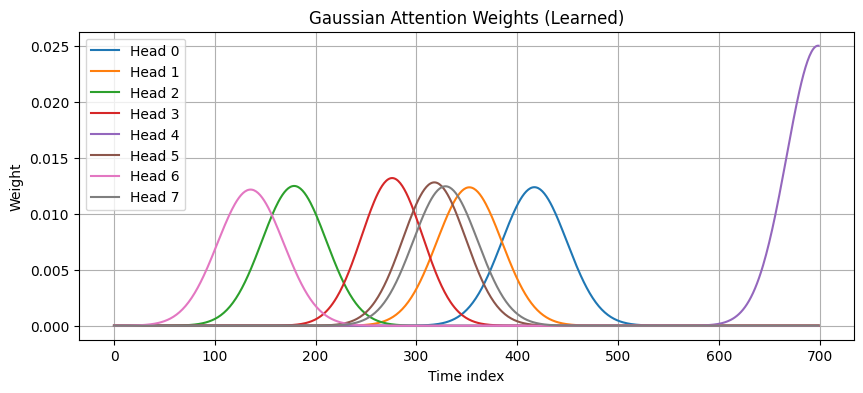

In [ ]:
plot_attention_heads(estra_stackable_1.get_layer('GaussiTrfmrBlock1_attn'))

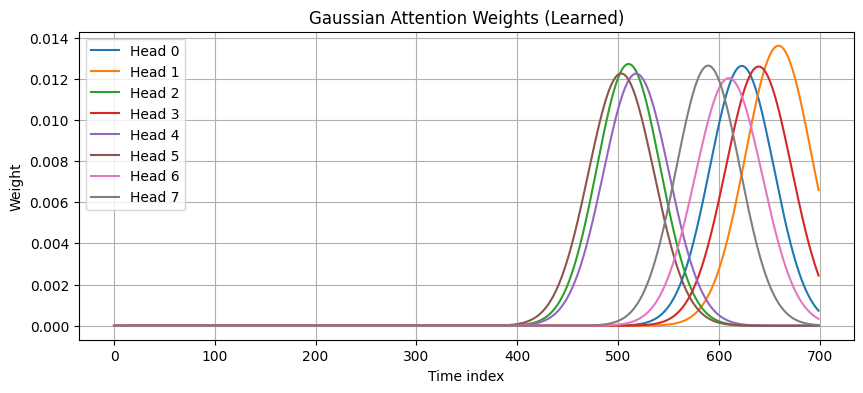

In [ ]:
plot_attention_heads(estra_stackable_1.get_layer('GaussiTrfmrBlock2_attn'))

### Evaluation on the validation set using key rank metric

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Trials: 100%|██████████| 10/10 [04:24<00:00, 26.40s/it]


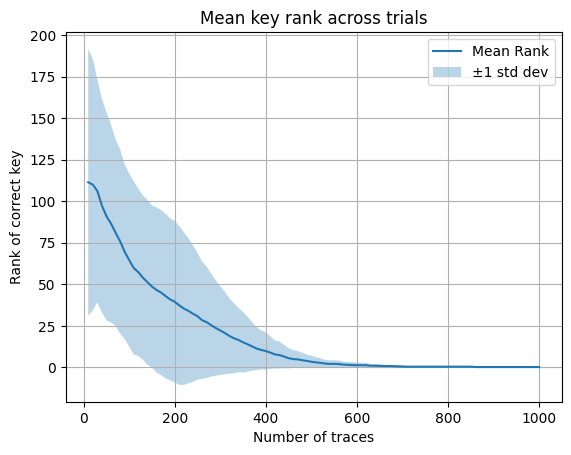

In [ ]:
predictions = estra_stackable_1.predict(X_val)
probas = tf.nn.softmax(predictions, axis=1).numpy()
steps, ranks = run_rank_trials(probas, metadata[val_idx], n_traces_per_trial=1000, n_trials=10)
plot_mean_rank(steps, ranks)

## SNR analysis

In [ ]:
plaintexts = np.array(metadata['plaintext'], dtype=np.uint8)
masks = np.array(metadata['masks'], dtype=np.uint8)
keys = np.array(metadata['key'], dtype=np.uint8)

target_byte=2
pt = plaintexts[:, target_byte]
m = masks[:, target_byte]
k = keys[:, target_byte]

In [ ]:
intermediate = SBOX[pt ^ k]  # Sbox(P ⊕ K)
labels = intermediate ^ m

In [ ]:
HW = np.array([bin(n).count("1") for n in range(0,256)])

In [ ]:
n_samples = 10000
targeted_sbox_index = 2

with h5py.File("/content/drive/MyDrive/ASCAD_databases/ASCAD.h5", "r") as f:
  l = f['Profiling_traces/traces'][:n_samples, :]
  l = l.astype(float)
  data = np.array(f['Profiling_traces/metadata'][:n_samples])
  k    = data['key'][:,targeted_sbox_index]
  p    = data['plaintext'][:,targeted_sbox_index]
  r    = data['masks'][:,targeted_sbox_index-2]
  rout = data['masks'][:,15]

id_label_withMaskRout    = SBOX[k^p]^rout
hw_label_withMaskRout    = HW[id_label_withMaskRout]
id_label_withoutMaskRout = id_label_withMaskRout^rout
hw_label_withoutMaskRout = HW[id_label_withoutMaskRout]
id_label_withMaskR       = SBOX[k^p]^r

# Unmasked - Sbox[k ^ p] ^ m

In [ ]:
trace_length = l.shape[1]
meanMaskedLin = np.zeros([256,trace_length])
varMaskedLin  = np.zeros([256,trace_length])
cptMaskedLin  = np.zeros(256)
i = 0

for trace in l:
    meanMaskedLin[id_label_withMaskR[i]] += trace
    varMaskedLin[id_label_withMaskR[i]]  += np.square(trace)
    cptMaskedLin[id_label_withMaskR[i]]  += 1
    i+=1

for i in range(256):
    meanMaskedLin[i] = meanMaskedLin[i] / cptMaskedLin[i]
    varMaskedLin[i]  = varMaskedLin[i]  / cptMaskedLin[i] - np.square(meanMaskedLin[i])

In [ ]:
varMeanMaskedLin = np.var  (meanMaskedLin,0)
MeanVarMaskedLin = np.mean (varMaskedLin,0)

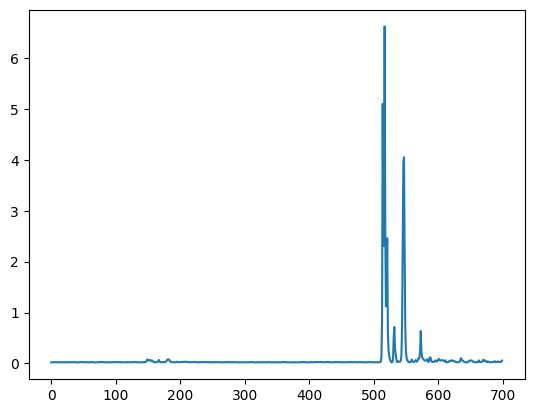

In [ ]:
plt.plot(varMeanMaskedLin/MeanVarMaskedLin)

# Masked - plain Sbox[k ^ p]

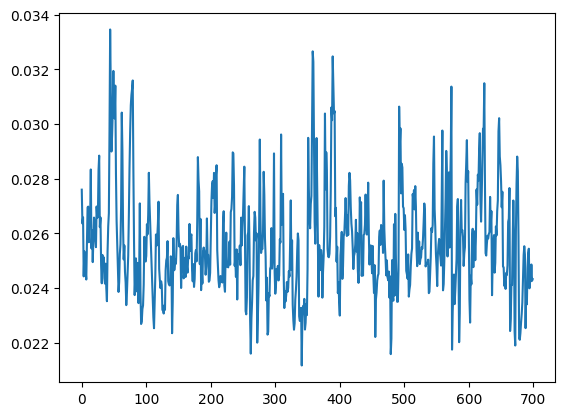

In [ ]:
trace_length = l.shape[1]
mean = np.zeros([256,trace_length])
var  = np.zeros([256,trace_length])
cpt  = np.zeros(256)
i = 0

for trace in l:
    mean[id_label_withoutMaskRout[i]]  += trace
    var [id_label_withoutMaskRout[i]]  += np.square(trace)
    cpt [id_label_withoutMaskRout[i]]  += 1
    i+=1

for i in range(256):
    mean[i] = mean[i] / cpt[i]
    var[i]  = var[i]  / cpt[i] - np.square(mean[i])


varMeanPlainSbox = np.var  (mean,0)
MeanVarPlainSbox = np.mean (var,0)

plt.plot(varMeanPlainSbox/MeanVarPlainSbox)

## Just rout

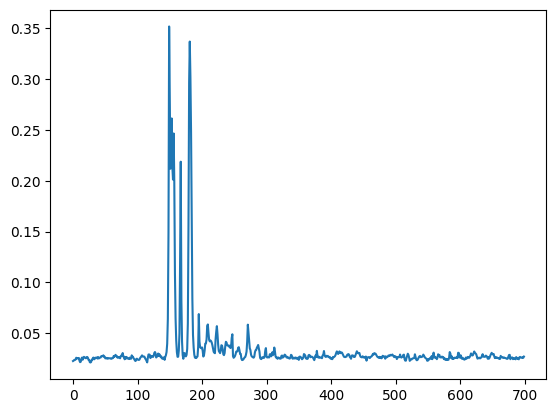

In [ ]:
trace_length = l.shape[1]
meanRout = np.zeros([256,trace_length])
varRout  = np.zeros([256,trace_length])
cptRout  = np.zeros(256)
i = 0

for trace in l:
    meanRout[rout[i]] += trace
    varRout [rout[i]]  += np.square(trace)
    cptRout [rout[i]]  += 1
    i+=1

for i in range(256):
    meanRout[i] = meanRout[i] / cptRout[i]
    varRout[i]  = varRout[i]  / cptRout[i] - np.square(meanRout[i])

varMeanRout = np.var  (meanRout,0)
MeanVarRout = np.mean (varRout,0)

plt.plot(varMeanRout/MeanVarRout)

## Unmasked - SBOX[k ^ p] ^ rout

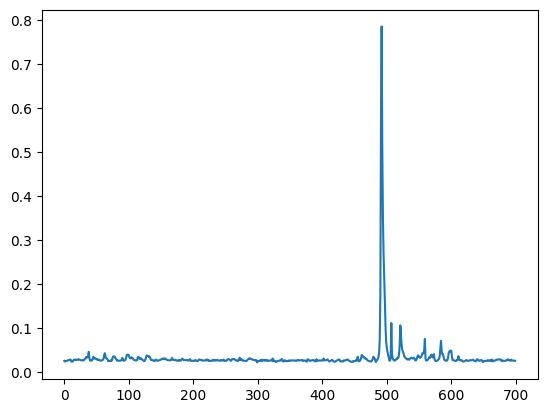

In [ ]:
trace_length = l.shape[1]
mean2 = np.zeros([256,trace_length])
var2  = np.zeros([256,trace_length])
cpt2  = np.zeros(256)
i = 0

for trace in l:
    mean2[id_label_withMaskRout[i]]  += trace
    var2 [id_label_withMaskRout[i]]  += np.square(trace)
    cpt2 [id_label_withMaskRout[i]]  += 1
    i+=1

for i in range(256):
    mean2[i] = mean2[i] / cpt2[i]
    var2[i]  = var2[i]  / cpt2[i] - np.square(mean2[i])


varMeanMaskedRout = np.var  (mean2,0)
MeanVarMaskedRout = np.mean (var2,0)

plt.plot(varMeanMaskedRout/MeanVarMaskedRout)

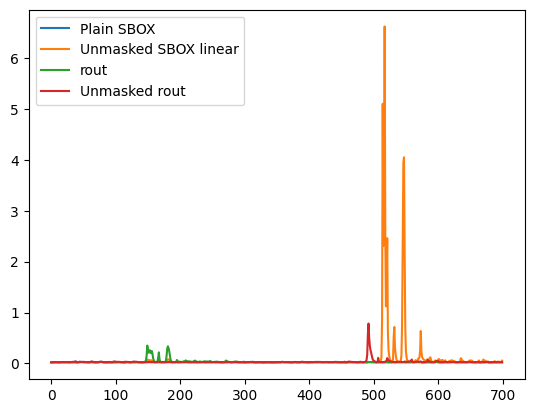

In [ ]:
plt.plot(varMeanPlainSbox/MeanVarPlainSbox, label="Plain SBOX")
plt.plot(varMeanMaskedLin/MeanVarMaskedLin, label="Unmasked SBOX linear")
plt.plot(varMeanRout/MeanVarRout, label="rout")
plt.plot(varMeanMaskedRout/MeanVarMaskedRout, label="Unmasked rout")

plt.legend()

plt.show()

## EstraNet - study

* mu initialization experiment
* Remove softmax normalization
* Add layer centering

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class GaussianAttention(tf.keras.layers.Layer):
    def __init__(self, seq_len, n_heads, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.n_heads = n_heads

    def build(self, input_shape):
      # μ initialization
      init_mu = tf.keras.initializers.Constant(value=self.seq_len // 2)
      self.mu = self.add_weight(
          shape=(self.n_heads,),
          initializer=init_mu,
          trainable=True,
          name="mu"
      )

      # σ initialization (wider spread)
      init_sigma = tf.keras.initializers.Constant(value=30.0)
      self.sigma = self.add_weight(
          shape=(self.n_heads,),
          initializer=init_sigma,
          trainable=True,
          name="sigma"
      )

      # Static projection to attention heads
      self.proj = tf.keras.layers.Dense(self.n_heads)

    def call(self, inputs):
        B = tf.shape(inputs)[0]
        T = self.seq_len

        # Layer centering
        centered_inputs = inputs - tf.reduce_mean(inputs, axis=-1, keepdims=True)

        # Time indices
        time = tf.range(0, T, dtype=tf.float32)
        time = tf.reshape(time, (1, T, 1))  # (1, T, 1)

        mu = tf.reshape(self.mu, (1, 1, self.n_heads))
        sigma = tf.reshape(self.sigma, (1, 1, self.n_heads))

        weights = tf.exp(-0.5 * ((time - mu) / (sigma + 1e-6))**2)

        # Remove softmax
        # weights /= tf.reduce_sum(weights, axis=1, keepdims=True)

        # Project input to H heads
        proj = self.proj(inputs)  # (B, T, H)

        # Attention-weighted sum
        attended = tf.reduce_sum(proj * weights, axis=1)  # (B, H)
        return attended


In [ ]:
from tensorflow.keras.layers import Dense, ReLU, BatchNormalization, Dropout, Add

def GaussianTransformerBlock(x_in, seq_len, n_heads, ffn_dim=128, dropout_rate=0.3, name_prefix="gblock"):
    attn_out = GaussianAttention(seq_len=seq_len, n_heads=n_heads, name=f"{name_prefix}_attn")(x_in)

    if x_in.shape[-1] != attn_out.shape[-1]:
        x_proj = Dense(attn_out.shape[-1])(x_in)
    else:
        x_proj = x_in

    x = Add()([x_proj, attn_out])
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    ffn = Dense(ffn_dim)(x)
    ffn = ReLU()(ffn)
    ffn = Dense(attn_out.shape[-1])(ffn)

    x = Add()([x, ffn])
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    return x

In [ ]:
## Stack Gaussi attentions

from tensorflow.keras.layers import Input, Conv1D, ReLU, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model

def build_estranet_stackable_mu_init(seq_len=700, num_classes=256, n_heads=8, conv_filters=32, gaussip_attn_layers=1):
    inputs = Input(shape=(seq_len, 1))

    # 1st Conv layer
    x = Conv1D(32, kernel_size=11, padding='same')(inputs)
    x = ReLU()(x)

    # 2nd Conv layer
    x = Conv1D(64, kernel_size=5, padding='same')(x)
    x = ReLU()(x)

    # 3rd Conv layer
    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = ReLU()(x)

    # 2. Gaussian attention block
    for i in range(gaussip_attn_layers):
      x = GaussianTransformerBlock(x, seq_len=seq_len, n_heads=n_heads, ffn_dim=128, name_prefix=f"GaussiTrfmrBlock{i}")

    x = GlobalAveragePooling1D()(x)

    # x = Dense(128)(attn)
    # x = ReLU()(x)
    # x = BatchNormalization()(x)
    # x = Dropout(0.3)(x)

    x = Dense(128)(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(256)(x)

    model = Model(inputs, outputs, name="EstraNet")
    return model


In [ ]:
estra_stackable_mu_init = build_estranet_stackable_mu_init(gaussip_attn_layers=4)

In [ ]:
estra_stackable_mu_init.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
hist_stackable_mu_init = estra_stackable_mu_init.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=128,
    epochs=100
)

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 55s 78ms/step - accuracy: 0.0044 - loss: 5.5566 - val_accuracy: 0.0032 - val_loss: 13.5612
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0054 - loss: 5.5437 - val_accuracy: 0.0044 - val_loss: 7.2697
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0066 - loss: 5.5402 - val_accuracy: 0.0040 - val_loss: 6.2913
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0048 - loss: 5.5390 - val_accuracy: 0.0040 - val_loss: 5.9364
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0056 - loss: 5.5367 - val_accuracy: 0.0030 - val_loss: 14.7725
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0057 - loss: 5.5344 - val_accuracy: 0.0042 - val_loss: 6.0495
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0069 - loss: 5.5305 - val_accuracy: 0.0058 - val_loss: 6.6776
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0070 - loss: 5.5277

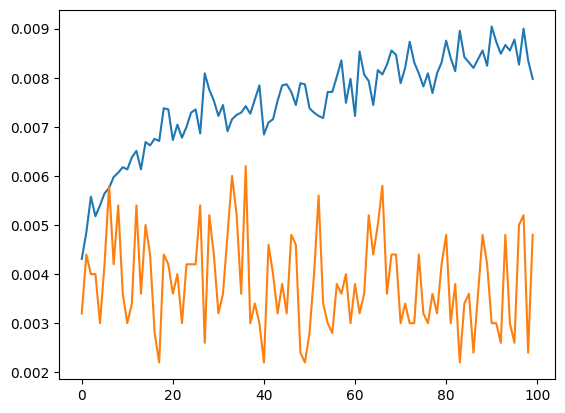

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist_stackable_mu_init.history['accuracy'])
plt.plot(hist_stackable_mu_init.history['val_accuracy'])
plt.show()

# plt.plot(hist_stackable_mu_init.history['loss'])
# plt.plot(hist_stackable_mu_init.history['val_loss'])
# plt.show

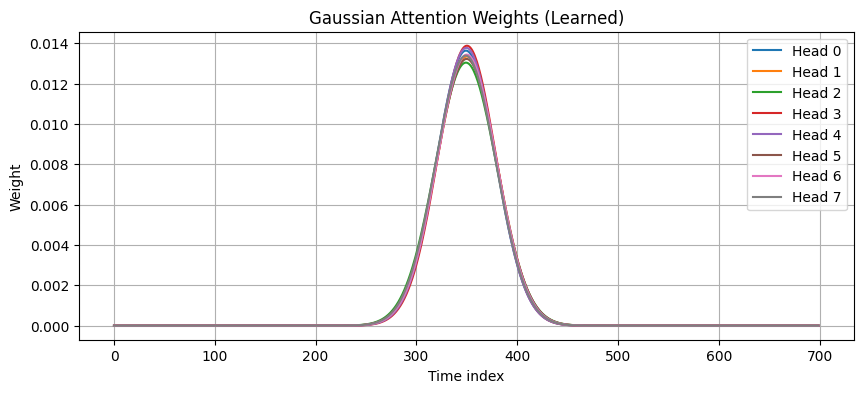

In [ ]:
plot_attention_heads(estra_stackable_mu_init.get_layer('GaussiTrfmrBlock0_attn'))

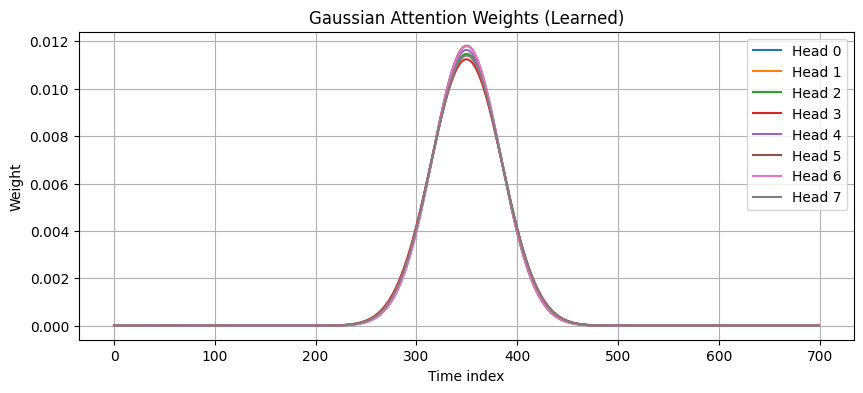

In [ ]:
plot_attention_heads(estra_stackable_mu_init.get_layer('GaussiTrfmrBlock1_attn'))

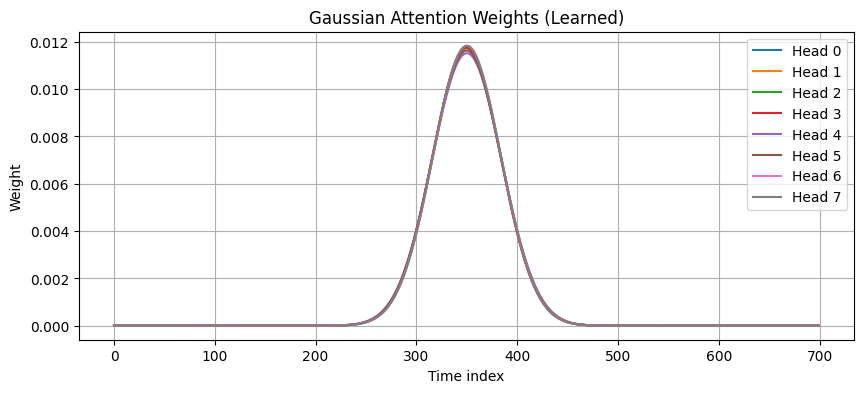

In [ ]:
plot_attention_heads(estra_stackable_mu_init.get_layer('GaussiTrfmrBlock2_attn'))

Initializing all of the heads at the same center seems to be unproductive, even the authorst of EstraNet state that



> We found that the
proper initialization of cp and sp for each head is crucial for the successful training of
EstraNet. We initialize sp for all heads to the same value 1. However, we initialize cp for
h-th head to (1 + 2h)/2H for h = 0, 1, . . . , H − 1. In other words, cps are initialized so
that different attention heads focus on different parts of the input sequence

This aligns with the results I got from initializing μ's to random starting positions.


# Hyperparameter tuning

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.8 MB/s eta 0:00:00


In [ ]:
#TODO: separate into util module

import keras_tuner as kt
import tensorflow.keras.backend as K
from tensorflow.keras.models import clone_model

class CleanMemoryTuner(kt.RandomSearch):
  """! Keras tuner wrapper to cleanup memory after each run.  """
  def run_trial(self, trial, *args, **kwargs):
    K.clear_session()
    return super().run_trial(trial, *args, **kwargs)

Define configurable model function

In [ ]:
## Stack Gaussi attentions

from tensorflow.keras.layers import Input, Conv1D, ReLU, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model

def build_estranet_configurable(seq_len=700, num_classes=256,
                                n_heads=8,
                                conv_filters=[32,64,128],
                                kernel_sizes=[11, 5, 3],
                                gaussip_attn_layers=1,
                                ffn_dimension=128,
                                dense_layers=128,
                                dropout=0.3):

    inputs = Input(shape=(seq_len, 1))

    # 1st Conv layer
    x = Conv1D(conv_filters[0], kernel_size=kernel_sizes[0], padding='same')(inputs)
    x = ReLU()(x)

    # 2nd Conv layer
    x = Conv1D(conv_filters[1], kernel_size=kernel_sizes[1], padding='same')(x)
    x = ReLU()(x)

    # 3rd Conv layer
    x = Conv1D(conv_filters[2], kernel_size=kernel_sizes[2], padding='same')(x)
    x = ReLU()(x)

    # 2. Gaussian attention blocks
    for i in range(gaussip_attn_layers):
      x = GaussianTransformerBlock(x,
                                   seq_len=seq_len,
                                   n_heads=n_heads,
                                   ffn_dim=ffn_dimension,
                                   name_prefix=f"GaussiTrfmrBlock{i}")

    x = GlobalAveragePooling1D()(x)

    # x = Dense(128)(attn)
    # x = ReLU()(x)
    # x = BatchNormalization()(x)
    # x = Dropout(0.3)(x)

    x = Dense(dense_layers)(x)
    x = ReLU()(x)
    x = Dropout(dropout)(x)

    outputs = Dense(num_classes)(x)

    model = Model(inputs, outputs, name="EstraNet")
    return model

In [ ]:
import tensorflow as tf
# from tf.keras.optimizers import Adam, RMSprop

def estra_clone_builder(hp):
  """! Hypermodel function - model builder for tuner
  """
  base_filters = hp.Choice("filter_scale", [1.0, 1.5, 2.0, 2.5, 3.0])
  conv_filters_hp = [int(f * base_filters) for f in [32, 64, 128]]
  # kernel_sizes_hp = hp.Choice("kernel_sizes", [[11,5,3], [11,11,11], [11,6,4]])
  kernel_sizes_hp = [hp.Choice("kernel_size_1", [15, 11, 8]),
                     hp.Choice("kernel_size_2", [8, 5, 3]),
                     hp.Choice("kernel_size_3", [3, 2, 1])]
  dropout_hp = hp.Float('dropout', 0.0, 0.6, step=0.2)
  n_attn_heads_hp = hp.Choice('n_heads', [8, 10, 12, 14, 16])
  n_attn_layers_hp = hp.Choice('n_attn_layers', [1, 4, 6, 8, 10])

  ffn_dims_hp = hp.Choice('ffn_dim_dense_layers', [1024, 512, 256, 128, 64])

  model = build_estranet_configurable(
      n_heads=n_attn_heads_hp,
      conv_filters=conv_filters_hp,
      kernel_sizes=kernel_sizes_hp,
      gaussip_attn_layers=n_attn_layers_hp,
      ffn_dimension=ffn_dims_hp,
      dense_layers=ffn_dims_hp,
      dropout=dropout_hp
  )

  learning_rate = hp.Float("learning_rate", min_value=1e-6, max_value=1e-2, sampling="log")

  optimizer_hp = hp.Choice("optimizers", ["rmsprop", "adam"])

  optim_dict = {
      "rmsprop" : tf.keras.optimizers.RMSprop(learning_rate),
      "adam" : tf.keras.optimizers.Adam(learning_rate)
  }

  optimizer = optim_dict[optimizer_hp]
  model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

  return model

In [ ]:
estra_tuner = CleanMemoryTuner(
    hypermodel=estra_clone_builder,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=1,
    directory="/content/drive/MyDrive/estra_tuner",
    project_name="estra_clone_hypersearch",
    overwrite=False
)

Reloading Tuner from /content/drive/MyDrive/estra_tuner/estra_clone_hypersearch/tuner0.json


In [ ]:
estra_tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/estra_tuner/estra_clone_hypersearch
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 27 summary
Hyperparameters:
filter_scale: 2.0
kernel_size_1: 8
kernel_size_2: 8
kernel_size_3: 3
dropout: 0.0
n_heads: 14
n_attn_layers: 1
ffn_dim_dense_layers: 1024
learning_rate: 0.0004373129547211047
optimizers: adam
Score: 5.4680938720703125

Trial 02 summary
Hyperparameters:
filter_scale: 3.0
kernel_size_1: 11
kernel_size_2: 3
kernel_size_3: 2
dropout: 0.2
n_heads: 10
n_attn_layers: 1
ffn_dim_dense_layers: 256
learning_rate: 3.0165685195813205e-05
optimizers: adam
Score: 5.504080772399902

Trial 20 summary
Hyperparameters:
filter_scale: 3.0
kernel_size_1: 8
kernel_size_2: 3
kernel_size_3: 2
dropout: 0.4
n_heads: 8
n_attn_layers: 1
ffn_dim_dense_layers: 512
learning_rate: 0.00025822982442214596
optimizers: adam
Score: 5.51188850402832

Trial 07 summary
Hyperparameters:
filter_scale: 2.5
kernel_size_1: 8
kernel_size_2: 8
kern

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/estra_trial_checkpoint.keras", save_best_only=True)

# Run hyperparameter random search
estra_tuner.search(X_train, Y_train, validation_data=(X_val, Y_val), callbacks=[early_stop, checkpoint], epochs=75, batch_size=128)

Trial 29 Complete [00h 26m 55s]
val_loss: 5.544724941253662

Best val_loss So Far: 5.4680938720703125
Total elapsed time: 14h 36m 27s

Search: Running Trial #30

Value             |Best Value So Far |Hyperparameter
2.5               |2                 |filter_scale
11                |8                 |kernel_size_1
5                 |8                 |kernel_size_2
1                 |3                 |kernel_size_3
0                 |0                 |dropout
10                |14                |n_heads
10                |1                 |n_attn_layers
1024              |1024              |ffn_dim_dense_layers
3.0147e-05        |0.00043731        |learning_rate
rmsprop           |adam              |optimizers

Epoch 1/75
352/352 ━━━━━━━━━━━━━━━━━━━━ 131s 264ms/step - accuracy: 0.0037 - loss: 5.5454 - val_accuracy: 0.0046 - val_loss: 5.5454
Epoch 2/75
352/352 ━━━━━━━━━━━━━━━━━━━━ 63s 179ms/step - accuracy: 0.0041 - loss: 5.5452 - val_accuracy: 0.0042 - val_loss: 5.5453
Epoch 3/75

### Train the best model

Run training using the best model on the whole profiling set

In [ ]:
best_hps = estra_tuner.get_best_hyperparameters(1)[0]
best_estra_clone = estra_tuner.hypermodel.build(best_hps)
best_estra_clone.summary()

Model: "EstraNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 700, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 700, 64)   │        576 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 700, 64)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 700, 128)  │     65,664 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 700, 128)  │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 700, 256)  │     98,560 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 700, 256)  │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 700, 14)   │      3,598 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GaussiTrfmrBlock0_… │ (None, 14)        │      3,626 │ re_lu_2[0][0]     │
│ (GaussianAttention) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 700, 14)   │          0 │ dense_1[0][0],    │
│                     │                   │            │ GaussiTrfmrBlock… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 700, 14)   │         56 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 700, 14)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 700, 1024) │     15,360 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 700, 1024) │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 700, 14)   │     14,350 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 700, 14)   │          0 │ dropout[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 700, 14)   │         56 │ add_1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 700, 14)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 14)        │          0 │ dropout_1[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1024)      │     15,360 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 1024)      │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 479,606 (1.83 MB)

 Trainable params: 479,550 (1.83 MB)

 Non-trainable params: 56 (224.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_full = ModelCheckpoint("/content/drive/MyDrive/estra_clone_full_training_chckpnt.keras", monitor='accuracy', save_best_only=True)

best_estra_hist = best_estra_clone.fit(x=X_profiling, y=Y_profiling, epochs=100, batch_size=128)

best_estra_clone.save("/content/drive/MyDrive/estra_clone_full_training.keras")

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 70ms/step - accuracy: 0.0043 - loss: 5.5451
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.0045 - loss: 5.5438
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.0045 - loss: 5.5408
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.0068 - loss: 5.5163
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.0074 - loss: 5.4896
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.0081 - loss: 5.4734
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.0094 - loss: 5.4221
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.0120 - loss: 5.3715
Epoch 9/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.0117 - loss: 5.3499
Epoch 10/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.0118 - loss: 5.3290
Epoch 11/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.0146 - loss: 5.3098
Epoch 12/100
391/39

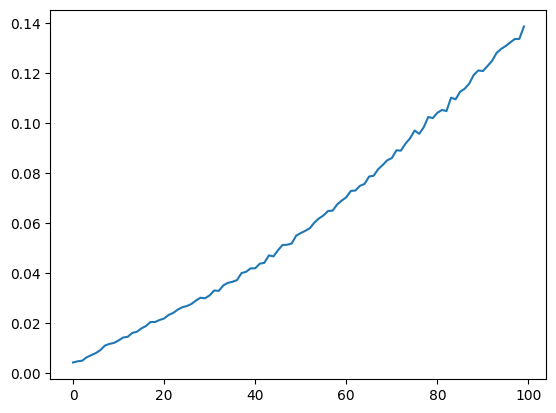

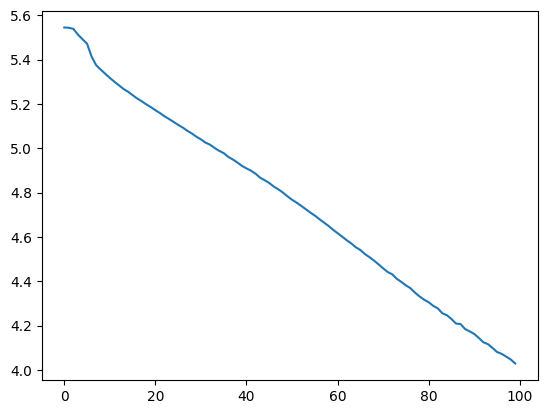

In [ ]:
import matplotlib.pyplot as plt

plt.plot(best_estra_hist.history['accuracy'])
# plt.plot(best_estra_hist.history['val_accuracy'])
plt.show()


plt.plot(best_estra_hist.history['loss'])
# plt.plot(best_estra_hist.history['val_loss'])
plt.show()

In [ ]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/estra_clone_full_training.keras", custom_objects={'GaussianAttention': GaussianAttention})

In [ ]:
snr = varMeanMaskedLin/MeanVarMaskedLin

In [ ]:
min(snr)

np.float64(0.020034914811769833)

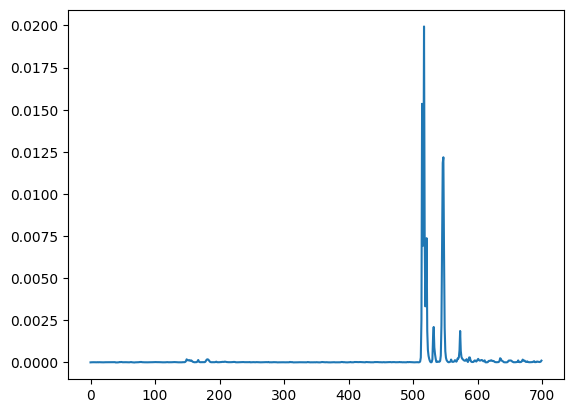

In [ ]:
snr_scaled = 0.02 * ((snr - min(snr)) / max(snr))
plt.plot(snr_scaled)

#### Plot the attention heads

Overlay the learned attentions over the SNR spikes in data.

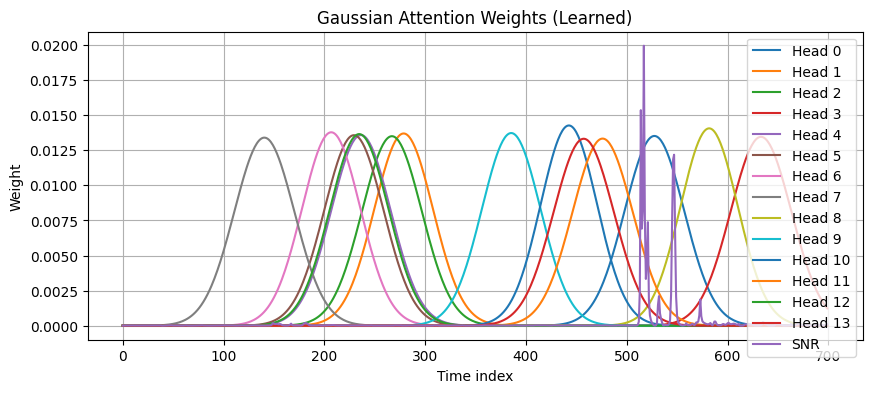

In [ ]:
plot_attention_heads(best_estra_clone.get_layer('GaussiTrfmrBlock0_attn'), snr=snr_scaled)

In [ ]:
plot_attention_heads(best_estra_clone.get_layer('GaussiTrfmrBlock1_attn'), snr=snr_scaled)

In [ ]:
plot_attention_heads(best_estra_clone.get_layer('GaussiTrfmrBlock2_attn'), snr=snr_scaled)

In [ ]:
plot_attention_heads(best_estra_clone.get_layer('GaussiTrfmrBlock3_attn'), snr=snr_scaled)

In [ ]:
plot_attention_heads(best_estra_clone.get_layer('GaussiTrfmrBlock4_attn'), snr=snr_scaled)

In [ ]:
plot_attention_heads(best_estra_clone.get_layer('GaussiTrfmrBlock5_attn'), snr=snr_scaled)

### Evaluate the rank metrics

After the full training has been performed, run the predictions on the attack set.

In [ ]:
ascad_path = "/content/drive/MyDrive/ASCAD_databases/ASCAD.h5"

with h5py.File(ascad_path, "r") as f:
  X_attack = np.array(f['Attack_traces/traces'], dtype=np.float32)
  Y_attack = np.array(f['Attack_traces/labels'], dtype=np.int64)
  attack_metadata = np.array(f['Attack_traces/metadata'])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Trials: 100%|██████████| 10/10 [04:24<00:00, 26.41s/it]


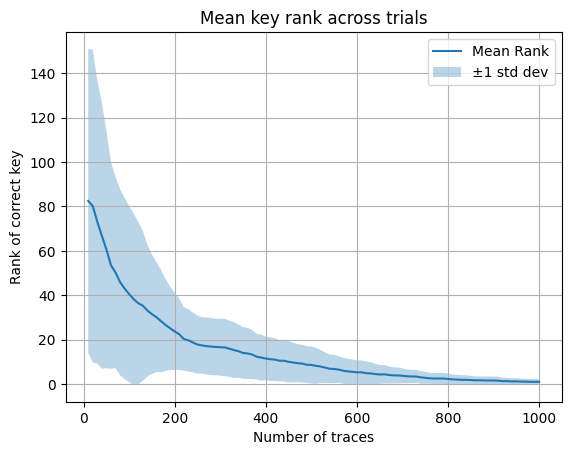

In [ ]:
attack_predictions = best_estra_clone.predict(X_attack)
probas = tf.nn.softmax(attack_predictions, axis=1).numpy()
steps, ranks = run_rank_trials(probas, attack_metadata, n_traces_per_trial=1000, n_trials=10)
plot_mean_rank(steps, ranks)

Best Estra clone network achieved pretty solid results on the attack set.

## GaussiP

Adopt more self-attention-like layer

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, Add, BatchNormalization, ReLU, Input # Added for block
from tensorflow.keras.models import Model # Added for block example
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class GaussiPInspiredAttention_OT2(tf.keras.layers.Layer):
    def __init__(self, n_heads, d_out_head, seq_len, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.n_heads = n_heads
        self.d_out_head = d_out_head
        self.seq_len = seq_len
        self.dropout_rate = dropout_rate

        if seq_len is None:
            raise ValueError("`seq_len` must be provided for GaussiPInspiredAttention_OT2.")

        i_indices = tf.range(self.seq_len, dtype=tf.float32)
        j_indices = tf.range(self.seq_len, dtype=tf.float32)
        relative_indices = tf.expand_dims(i_indices, 1) - tf.expand_dims(j_indices, 0)
        self.relative_indices_h_view = tf.expand_dims(relative_indices, 0) # (1, T, T)

    def build(self, input_shape):
        # input_shape is (B, T, C_in). C_in is the model_dim.
        self.model_dim = input_shape[-1] # Dimension to project back to
        T_float = tf.cast(self.seq_len, dtype=tf.float32)

        init_cp_values = (1.0 + 2.0 * tf.range(self.n_heads, dtype=tf.float32)) / (2.0 * float(self.n_heads))
        self.c_p_heads = self.add_weight(
            shape=(self.n_heads, 1, 1),
            initializer=tf.keras.initializers.Constant(tf.reshape(init_cp_values, (self.n_heads, 1, 1))),
            trainable=True,
            name="c_p_heads"
        )
        self.precision_factors = self.add_weight(
            shape=(self.n_heads, 1, 1),
            initializer=tf.keras.initializers.Constant(10.0), # Tunable initial value
            trainable=True,
            name="precision_factors"
        )
        self.dense_v = Dense(self.n_heads * self.d_out_head, name="value_projection", use_bias=False)
        self.dense_o = Dense(self.model_dim, name="output_projection", use_bias=False) # Projects to model_dim
        self.attention_dropout_layer = Dropout(self.dropout_rate)

    def call(self, inputs, training=None):
        B = tf.shape(inputs)[0]
        T_float = tf.cast(self.seq_len, dtype=tf.float32)

        centered_relative_distance = self.relative_indices_h_view - (self.c_p_heads * T_float)
        exponent_arg_squared = tf.square(centered_relative_distance * self.precision_factors)
        # Store for potential plotting
        self.attention_scores_unnormalized_for_plot = tf.exp(-0.5 * exponent_arg_squared)

        attention_weights = tf.nn.softmax(self.attention_scores_unnormalized_for_plot, axis=2)
        attention_weights = self.attention_dropout_layer(attention_weights, training=training)
        # Store for potential plotting
        self.attention_weights_for_plot = attention_weights

        V = self.dense_v(inputs)
        V_reshaped = tf.reshape(V, (B, self.seq_len, self.n_heads, self.d_out_head))
        V_permuted = tf.transpose(V_reshaped, perm=[0, 2, 1, 3])

        context_vectors = tf.einsum('hij,bhjd->bhid', attention_weights, V_permuted)
        context_vectors_transposed = tf.transpose(context_vectors, perm=[0, 2, 1, 3])
        output_concat_heads = tf.reshape(context_vectors_transposed, (B, self.seq_len, self.n_heads * self.d_out_head))
        output = self.dense_o(output_concat_heads)
        return output

In [ ]:
def GaussianTransformerBlock_EstraInspired(
    x_in,
    seq_len,
    n_heads,
    d_out_head, # Dimension for each attention head's V and internal computations
    # model_dim will be inferred from x_in.shape[-1] by the attention layer
    ffn_dim=128,
    dropout_rate=0.3,
    use_batch_norm=True, # Option to switch to LayerNorm
    name_prefix="gblock_estra"
    ):

    # model_dim is the feature dimension of the input x_in and the output of this block
    model_dim = x_in.shape[-1]

    # 1. Gaussian-Inspired Sequence-to-Sequence Attention
    attn_layer = GaussiPInspiredAttention_OT2(
        n_heads=n_heads,
        d_out_head=d_out_head,
        seq_len=seq_len,
        dropout_rate=dropout_rate, # Pass dropout to attention
        name=f"{name_prefix}_gaussip_attn"
    )
    # attn_out will have shape (B, T, model_dim) because dense_o in GaussiPInspiredAttention_OT2 projects to it
    attn_out = attn_layer(x_in)

    # 2. Add & Norm (Post-Attention)
    # Since attn_out is (B, T, model_dim) and x_in is (B, T, model_dim), direct addition works.
    x = Add(name=f"{name_prefix}_add1")([x_in, attn_out])
    if use_batch_norm:
        x_norm1 = BatchNormalization(name=f"{name_prefix}_bn1")(x)
    else:
        # LayerNormalization is more common in Transformers and used in EstraNet (though they call it layer-centering)
        x_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=f"{name_prefix}_ln1")(x)
    x_drop1 = Dropout(dropout_rate, name=f"{name_prefix}_drop1")(x_norm1)

    # 3. Feed-Forward Network
    ffn = Dense(ffn_dim, activation='relu', name=f"{name_prefix}_ffn1")(x_drop1)
    ffn_drop = Dropout(dropout_rate, name=f"{name_prefix}_ffn_drop")(ffn)
    # Project FFN output back to model_dim to match for residual connection
    ffn_out = Dense(model_dim, name=f"{name_prefix}_ffn2")(ffn_drop)

    # 4. Add & Norm (Post-FFN)
    x2 = Add(name=f"{name_prefix}_add2")([x_drop1, ffn_out])
    if use_batch_norm:
        x_norm2 = BatchNormalization(name=f"{name_prefix}_bn2")(x2)
    else:
        x_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=f"{name_prefix}_ln2")(x2)
    x_out_block = Dropout(dropout_rate, name=f"{name_prefix}_drop2")(x_norm2)

    return x_out_block


In [ ]:
SEQ_LEN = 128
MODEL_DIM = 64
N_HEADS = 4
D_OUT_HEAD = 16
FFN_DIM = 256

In [ ]:
## Stack Gaussi attentions

from tensorflow.keras.layers import Input, Conv1D, ReLU, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Add
from tensorflow.keras.models import Model

def build_estra_gaussiP_squared(seq_len=700, num_classes=256, n_heads=8, conv_filters=32, gaussip_attn_layers=1):
    inputs = Input(shape=(seq_len, 1))

    # 1st Conv layer
    x = Conv1D(32, kernel_size=11, padding='same')(inputs)
    x = ReLU()(x)

    # 2nd Conv layer
    x = Conv1D(64, kernel_size=5, padding='same')(x)
    x = ReLU()(x)

    # 3rd Conv layer
    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = ReLU()(x)

    # 2. Gaussian attention block
    for i in range(gaussip_attn_layers):
      x = GaussianTransformerBlock_EstraInspired(x, seq_len=seq_len, n_heads=n_heads, d_out_head=D_OUT_HEAD, ffn_dim=128, name_prefix=f"GaussiTrfmrBlock{i}")

    x = GlobalAveragePooling1D()(x)

    # x = Dense(128)(attn)
    # x = ReLU()(x)
    # x = BatchNormalization()(x)
    # x = Dropout(0.3)(x)

    x = Dense(128)(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(256)(x)

    model = Model(inputs, outputs, name="EstraNet")
    return model


In [ ]:
test_model = build_estra_gaussiP_squared()
test_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
test_model.summary()

Model: "EstraNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 700, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 700, 32)   │        384 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 700, 32)   │          0 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 700, 64)   │     10,304 │ re_lu_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 700, 64)   │          0 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 700, 128)  │     24,704 │ re_lu_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 700, 128)  │          0 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GaussiTrfmrBlock0_… │ (None, 700, 128)  │     32,784 │ re_lu_8[0][0]     │
│ (GaussiPInspiredAt… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GaussiTrfmrBlock0_… │ (None, 700, 128)  │          0 │ re_lu_8[0][0],    │
│ (Add)               │                   │            │ GaussiTrfmrBlock… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GaussiTrfmrBlock0_… │ (None, 700, 128)  │        512 │ GaussiTrfmrBlock… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GaussiTrfmrBlock0_… │ (None, 700, 128)  │          0 │ GaussiTrfmrBlock… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GaussiTrfmrBlock0_… │ (None, 700, 128)  │     16,512 │ GaussiTrfmrBlock… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GaussiTrfmrBlock0_… │ (None, 700, 128)  │          0 │ GaussiTrfmrBlock… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GaussiTrfmrBlock0_… │ (None, 700, 128)  │     16,512 │ GaussiTrfmrBlock… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GaussiTrfmrBlock0_… │ (None, 700, 128)  │          0 │ GaussiTrfmrBlock… │
│ (Add)               │                   │            │ GaussiTrfmrBlock… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GaussiTrfmrBlock0_… │ (None, 700, 128)  │        512 │ GaussiTrfmrBlock… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GaussiTrfmrBlock0_… │ (None, 700, 128)  │          0 │ GaussiTrfmrBlock… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ GaussiTrfmrBlock… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p

 Total params: 151,760 (592.81 KB)

 Trainable params: 151,248 (590.81 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
test_model_hist = test_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=128,
    epochs=100
)

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 58s 101ms/step - accuracy: 0.0039 - loss: 5.5471 - val_accuracy: 0.0066 - val_loss: 8.2265
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.0053 - loss: 5.5442 - val_accuracy: 0.0048 - val_loss: 10.0630
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.0052 - loss: 5.5431 - val_accuracy: 0.0018 - val_loss: 8.7320
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.0046 - loss: 5.5416 - val_accuracy: 0.0044 - val_loss: 10.9622
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.0051 - loss: 5.5414 - val_accuracy: 0.0044 - val_loss: 11.7780
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.0053 - loss: 5.5404 - val_accuracy: 0.0054 - val_loss: 8.2374
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.0053 - loss: 5.5387 - val_accuracy: 0.0054 - val_loss: 6.9516
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.0059 - loss: 5.53

In [ ]:
test_model.save('/content/drive/MyDrive/estra_gaussip_closer.keras')

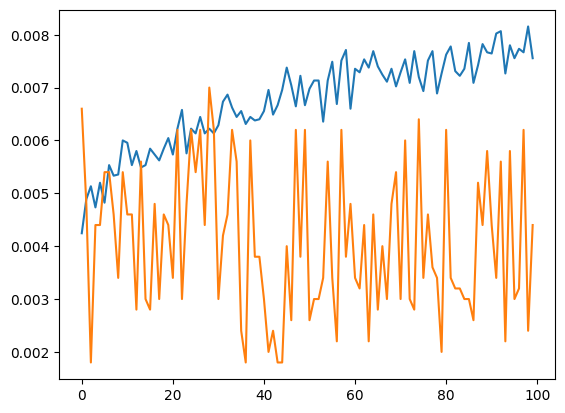

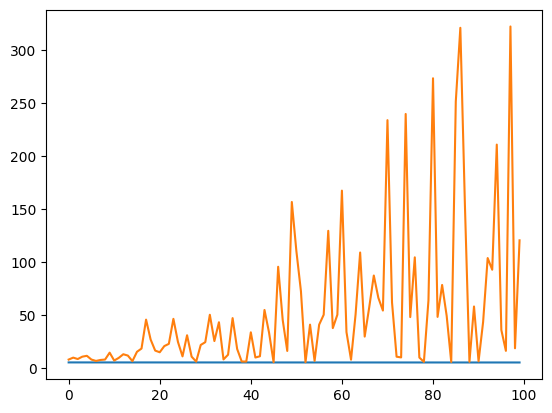

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_model_hist.history['accuracy'])
plt.plot(test_model_hist.history['val_accuracy'])
plt.show()

plt.plot(test_model_hist.history['loss'])
plt.plot(test_model_hist.history['val_loss'])
plt.show()